In [10]:
import gpxpy
import os
import glob

from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import contextily as ctx

In [8]:
# Function to parse GPX file and extract coordinates
def extract_coordinates(gpx_file):
    with open(gpx_file, 'r') as f:
        gpx = gpxpy.parse(f)
    coordinates = []
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                coordinates.append((point.latitude, point.longitude))
    return coordinates

# Function to compute DTW distance between two routes
def compute_dtw_distance(route1, route2):
    distance, _ = fastdtw(route1, route2, dist=euclidean)
    return distance

# Function to compute pairwise DTW distances for all GPX files in a directory
def compute_pairwise_dtw_distances(directory):
    files = [f for f in os.listdir(directory) if f.endswith('.gpx')]
    distances = {}
    for i in range(len(files)):
        for j in range(i + 1, len(files)):
            file1 = os.path.join(directory, files[i])
            file2 = os.path.join(directory, files[j])
            route1 = extract_coordinates(file1)
            route2 = extract_coordinates(file2)
            distance = compute_dtw_distance(route1, route2)
            distances[(files[i], files[j])] = distance
    return files, distances

# Function to create a heatmap from pairwise distances
def plot_heatmap(files, distances):
    # Create a DataFrame from distances
    df = pd.DataFrame(index=files, columns=files, dtype=float)
    for (file1, file2), distance in distances.items():
        df.loc[file1, file2] = distance
        df.loc[file2, file1] = distance  # Symmetric matrix

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df, annot=True, cmap='viridis', fmt='.1f', linewidths=.5)
    plt.title('Pairwise DTW Distances Heatmap')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def parse_gpx(filepath):
    gpx_file = open(filepath, 'r')
    gpx = gpxpy.parse(gpx_file)
    data = []
    
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                lat, lng = point.latitude, point.longitude
                data.append({
                  'latitude': lat, 
                  'longitude': lng,
                })

    df = pd.DataFrame(data)
    return df    
    
def plot_gpx(df, label):
    plt.figure(figsize=(15, 8))
    plt.plot(df['longitude'], df['latitude'], color='red', label=label)
    ctx.add_basemap(plt.gca(), crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
    plt.legend()
    plt.xticks([], [])
    plt.yticks([], [])
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    plt.show()    

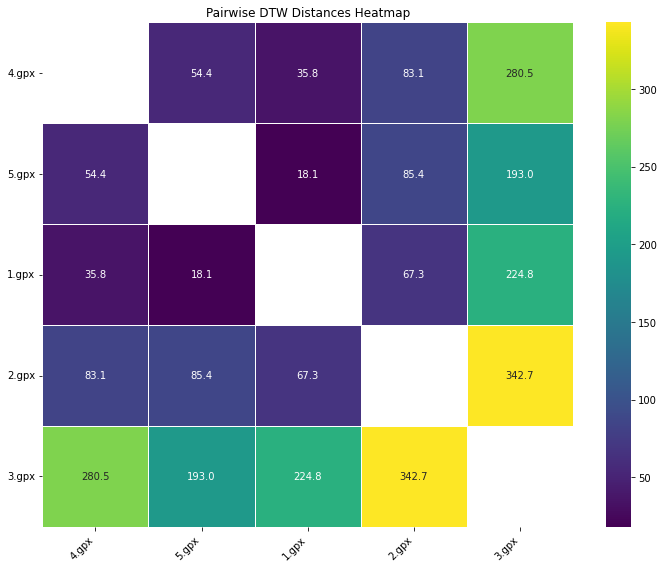

In [3]:
directory = '../gpx'

files, pairwise_distances = compute_pairwise_dtw_distances(directory)
plot_heatmap(files, pairwise_distances)

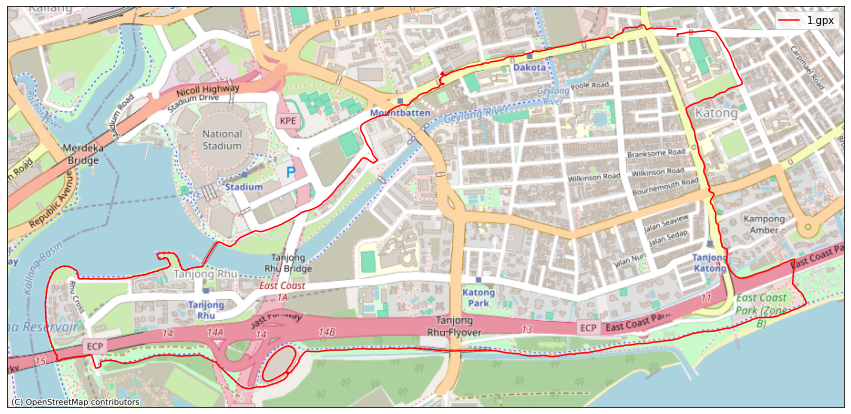

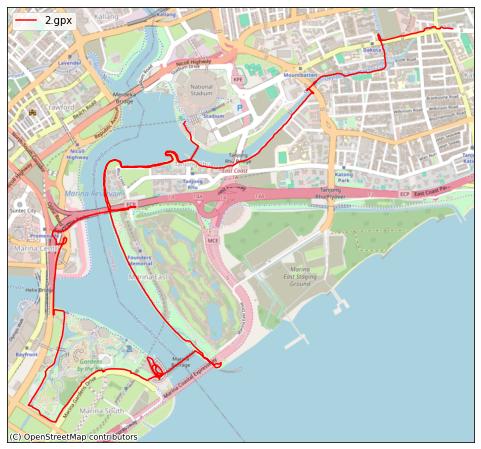

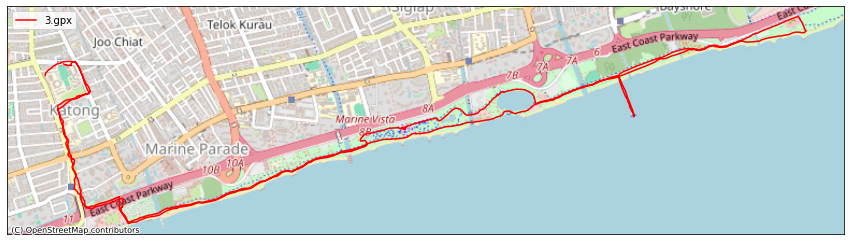

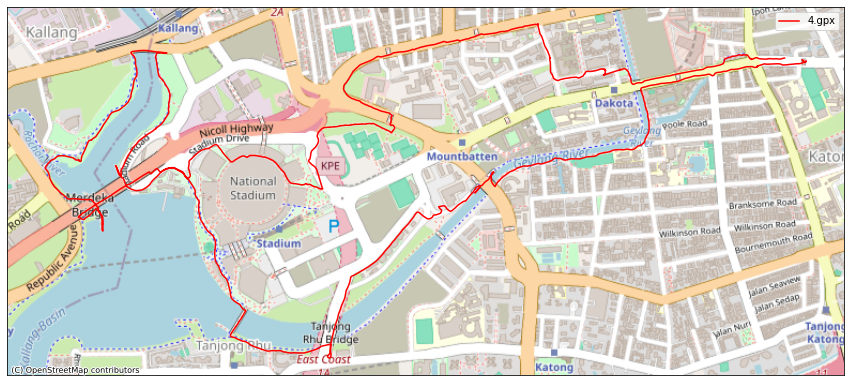

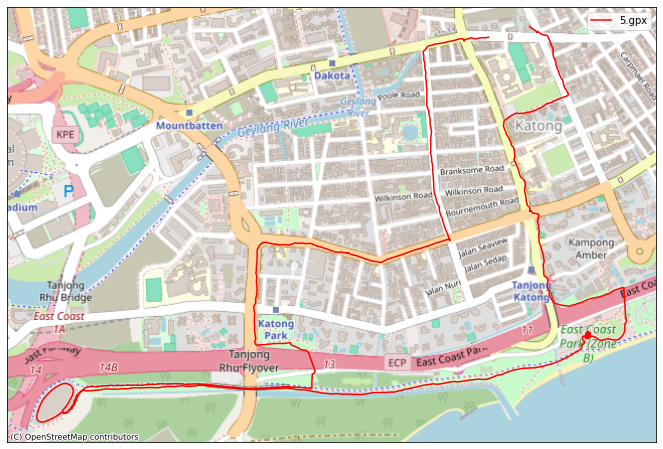

In [12]:
gpx_files = glob.glob(
  os.path.join("../gpx", '*.gpx')
)
gpx_files = sorted(gpx_files)
for gpx_file in gpx_files:
    df = parse_gpx(gpx_file)
    plot_gpx(df, os.path.basename(gpx_file))